# SETUP

In [1]:
import numpy as np
import itertools
import requests
import datetime
import time
import json
import sys
from datetime import datetime
import pickle
import pandas as pd
import rasterio as rio
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from rasterio.transform import Affine
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [2]:
print("matplotlib",matplotlib.__version__)
print("seaborn",sns.__version__)
print("numpy",np.__version__)
print("pandas",pd.__version__)
print("python",sys.version)

matplotlib 3.2.0
seaborn 0.10.0
numpy 1.18.1
pandas 1.0.1
python 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 21:48:41) [MSC v.1916 64 bit (AMD64)]


# Requests 

From GEO EDA sheet:

## DarkSky Sample

1) cheapest seems to be DarkSky. 1000 per day for free 2) $0.0001 per request after that 3) Request: " https://api.darksky.net/forecast/[key]/40.036944,-121.005833,2005-02-02T17:30:00" (my api key removed)

Output is like this: {"latitude":40.036944,"longitude":-121.005833,"timezone":"America/Los_Angeles","currently":{"time":1107394200,"precipIntensity":0,"precipProbability":0,"temperature":50.24,"apparentTemperature":50.41,"dewPoint":13.85,"humidity":0.23,"windSpeed":2.62,"windGust":13.17,"windBearing":24,"uvIndex":0},"hourly":{"data":
...
{"time":1107414000,"precipIntensity":0,"precipProbability":0,"temperature":41.2,"apparentTemperature":41.2,"dewPoint":12.53,"humidity":0.31,"windSpeed":1.56,"windGust":12.79,"windBearing":100,"uvIndex":0}]},"daily":{"data":[{"time":1107331200,"sunriseTime":1107357120,"sunsetTime":1107393960,"moonPhase":0.78,"precipIntensity":0,"precipIntensityMax":0,"precipProbability":0,"temperatureHigh":57.95,"temperatureHighTime":1107384600,"temperatureLow":38.42,"temperatureLowTime":1107439200,"apparentTemperatureHigh":57.45,"apparentTemperatureHighTime":1107384600,"apparentTemperatureLow":38.91,"apparentTemperatureLowTime":1107439200,"dewPoint":14.85,"humidity":0.31,"windSpeed":3.33,"windGust":14.83,"windGustTime":1107390840,"windBearing":76,"uvIndex":0,"uvIndexTime":1107331200,"temperatureMin":35.03,"temperatureMinTime":1107359100,"temperatureMax":57.95,"temperatureMaxTime":1107384600,"apparentTemperatureMin":34.3,"apparentTemperatureMinTime":1107338640,"apparentTemperatureMax":57.45,"apparentTemperatureMaxTime":1107384600}]},"flags":{"sources":["cmc","gfs","hrrr","icon","isd","madis","nam","sref"],"nearest-station":3.312,"units":"us"},"offset":-8}

## Dark Sky locality

In [ ]:
# From Geo Sheet - Toy Data Bounding Box
# keep in mind each pixel is roughly 500 m x 500 m
bb_long = [-122, -119.912,-119.912,-122,-122 ]
bb_lat = [36.8, 36.8, 35.06, 35.06,36.8]

Requests, to see how how 'hyperlocal' the darksky data really is.

In [ ]:
# Create Pairs
min_long = min(bb_long)
max_long = max(bb_long)
min_lat = min(bb_lat)
max_lat = max(bb_lat)

In [ ]:
spaces = 10
longs = np.linspace(min_long,max_long,spaces)
lats = np.linspace(min_lat,max_lat,spaces)
print(longs, lats)
distance = (max_lat-min_lat)*110/spaces
print(f"distance between forecast pairings ~ {distance:.3} km, or {(distance/.5):.3} pixels")

In [ ]:
# Pairs
pairs = [(lat,long) for lat in lats for long in longs]
print(len(pairs))
print(pairs[25])

In [ ]:
key = '5ffac5f056d341c6296cba58fa96e9ba'

The Forecast Data API supports HTTP compression. We heartily recommend using it, as it will make responses much smaller over the wire. To enable it, simply add an `Accept-Encoding: gzip` header to your request.

### Try one request

In [ ]:
# items to exclude from call
blocks = '[currently,minutely,hourly,alerts]'
# Units for call
units = 'ca'
# Time
time = '2005-02-02T12:00:00' # for noon, but hour doesn't matter as we're grabbing daily data only.
# Dates (relevant to our fires): only use one for testing
dates = ['2016-12-16']

# create time string:
date = dates[0]
time = date+'T12:00:00'
lat = str(pairs[25][0])
long = str(pairs[25][1])

query = ('https://api.darksky.net/forecast/'+key+'/'+ 
        lat+','+long+','+time+'?exclude=' 
        +blocks+'&units='+units)
headers = {'Accept-Encoding':'gzip'}
print(query)   

In [ ]:
d = requests.get('https://api.darksky.net/forecast/5ffac5f056d341c6296cba58fa96e9ba/36.8,-122.0,2016-07-21T12:00:00?exclude=[currently,minutely,hourly,alerts]&units=ca',headers=headers)
d.json()['daily']['data']

In [ ]:
r=requests.get(query,headers=headers)

In [ ]:
r.status_code

In [ ]:
weather = r.json()
weather['daily']['data']

In [ ]:
# Parsed important elements:
dailydata = weather['daily']['data'][0]
rainint = dailydata['precipIntensityMax']
raintot = dailydata['precipAccumulation']=0.0
hitemp = dailydata['temperatureHigh']
lotemp = dailydata['temperatureLow']
humidity = dailydata['humidity']
windspd = dailydata['windSpeed']
winddir = dailydata['windBearing']
clouds = dailydata['cloudCover']

In [ ]:
point = [date,lat,long,rainint,raintot,hitemp,lotemp,humidity,windspd,winddir,clouds]

In [ ]:
point

In [ ]:
print(type(point))

In [ ]:
pairs[0][0]

## Multiple Requests to determine degree of hyperlocality required

### Https requests functions

In [ ]:
# NEWER VERSION BELOW
# def getweather(coordinates,date,key):
#     """ Function to take the set of coordinates and get the daily
#     weather for a given date. rain, hi and low temps, humidity
#     wind speed and direction and cloud cover only.
    
#     Input: Date, API Key and list of coordinate pairs (lat,long)
#     Output: list of jsons
#     """
#     # items to exclude from call
#     blocks = '[currently,minutely,hourly,alerts]'

#     # Units for call
#     units = 'ca'
    
#     # Compression for call
#     headers = {'Accept-Encoding':'gzip'}
    
#     time = date+'T12:00:00'
    
#     data_out = []
#     for pair in coordinates:
#         lat = str(pair[0])
#         long = str(pair[1])
#         # set the query string for darksky
#         query = ('https://api.darksky.net/forecast/'+key+'/'+ 
#             lat+','+long+','+time+'?exclude=' 
#             +blocks+'&units='+units)
#         # Make the call to Dark Sky to get all the data for that date and location
#         r=requests.get(query,headers=headers)
        
#         # get the weather data from the request return
#         weather=r.json()
        
#         # write the jsons as items in the output data list
#         data_out.append(weather)
    
#     return data_out

In [ ]:
%%time
# Dates (relevant to our fires): only use one for testing
dates = ['2016-07-21']
# create time string:
date = dates[0]

data_for_date = getweather(pairs,date,key)

In [ ]:
%%time
# Pickle results out so that i don't have to make another api call later
with open('../data/GlobalFire2016/weathertest.pickle','wb') as f:
    pickle.dump(data_for_date,f,pickle.HIGHEST_PROTOCOL)

In [ ]:
def check_point(info,rain=False):
    """ to check if there is a value for that weather element and provide 
    either None or the value back
    """
    if info:
        return info
    elif (not info and rain):
        return 0.0        
    else:
        return None

In [ ]:
def date_df(data_out):
    """ Function to take the list of jsons from a date
    of daily weather requests and create a pandas dataframe
    
    Input: list of jsons containing the weather data
    Output: pandas dataframe
    """
    data_convert=[]
    # Titles for the data
    coltitles = ['date','latitude','longitude','rainint','raintot','High T','Low T','Humidity','Wind Speed','Wind Direction','Cloud Cover']
    data_convert.append(coltitles)
    # Loope through all the geopoints to get the data
    for point in data_out:
        lat = point['latitude']
        long = point['longitude']
        daily = point.get('daily')
        if daily:
            data = daily['data'][0]
            time = datetime.fromtimestamp(data['time']).strftime('%Y-%m-%d')
            rainint = data.get('precipIntensityMax')
            raintot = data.get('precipAccumulation')
            hitemp = data.get('temperatureHigh')
            lotemp = data.get('temperatureLow')
            humidity = data.get('humidity')
            windspd = data.get('windSpeed')
            winddir = data.get('windBearing')
            clouds = data.get('cloudCover')
            point = [date,lat,long,check_point(rainint,1),check_point(raintot,1), \
                     check_point(hitemp,0),check_point(lotemp,0), \
                     check_point(humidity,0),check_point(windspd,0), \
                     check_point(winddir,0), check_point(clouds,0)] 
            data_convert.append(point)
        else:
            point = None
            
    df = pd.DataFrame(data_convert[1:], columns = data_convert[0])
    
    return df


In [ ]:
with open('../data/GlobalFire2016/weathertest.pickle','rb') as f:
    data_for_date = pickle.load(f)
    
    # Dates (relevant to our fires): only use one for testing
dates = ['2016-07-21']
# create time string:
date = dates[0]
df2 = date_df(data_for_date)

In [ ]:
df2

If matrix is missing some rows then add them back in with NaN

In [ ]:
df3 = copy.deepcopy(df2)
df3['xx'] = list(zip(df3['latitude'],df3['longitude']))
df3

In [ ]:
missing = pd.DataFrame({'xx':list(set(df3['xx']) ^ set(pairs))})
missing[['latitude','longitude']]=pd.DataFrame(missing['xx'].tolist(),index=missing.index)
missing

In [ ]:
df4 = df3.append(missing, ignore_index=True, sort=True)
df4.shape

### Look at uniqueness

In [ ]:
stats = df2.describe()

In [ ]:
cols = stats.columns

In [ ]:
uniques = []
for col in cols:
    uniq = len(df2[col].value_counts())
    uniques.append(uniq)
uniques = pd.DataFrame([uniques],columns=cols)

In [ ]:
uniques.rename(index={0:'Uniques'},inplace = True)

In [ ]:
newstats = stats.append(uniques)
newstats

# Turn data into 2D numpy arrays

The above says that the data is fairly hyperlocal. Try doing heat maps?
To do heatmaps, have to turn this into a numpy array which i have to do anyway

## Create the numpy arrays

### Sample for 1 array (High Temp) For Reference

In [ ]:
# Create numpy array for High Temperature
# create a list of all the values by increasing longitude for each latitude, so we can vstack into array

# # Subset the dataframe
# sub = df2[['latitude','longitude','High T']]

# # All values of longitude, to ensure square matrix
# long_df = pd.DataFrame(longs,columns=['longitude'])

# hiT = []

# # reverse the latitudes so we start with largest first
# lats2 = list(copy.deepcopy(lats))
# lats2.reverse()

# # loop through each latitude
# for lat in lats2:
#     # get the row values for each latitude, sort by longitude
#     row = sub[sub['latitude']==lat].sort_values(by=['longitude'])
    
#     # add in missing longitude if necessary
#     row2 = long_df.merge(row,how='left')
    
#     # Fill any missing values of latitude if needed
#     row2['latitude'].fillna(lat,inplace=True)
    
#     # pull out just the High T
#     row3 = row2['High T']
    
#     # reshape array
#     row3 = np.array(row3)[np.newaxis] 
    
#     hiT.append(row3)

# x = np.vstack(hiT)
# For Reference
# hhh = HighTempArray
# hhh


### Looping to generate all weather for given day

In [ ]:
weather = ['rainint','raintot','High T','Low T','Humidity','Wind Speed','Wind Direction','Cloud Cover']

In [ ]:
weath_sort = df4.to_records(index=False)
weath_sort.sort(order=('latitude','longitude'))

In [ ]:
weather_date = {}
for var in weather:
    x = weath_sort[var].reshape(10,10)
    xx = np.flip(x,0)
    weather_date.update({var:xx})

In [ ]:
weather_date

In [ ]:
# REFERENCE PLOT
# ax = sns.heatmap(HighTempArray)  # Plotting HighTempArray but replaced -9999 with nan for plot

# # Fix the cutoff heatmap issue
# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values

# plt.show()

In [ ]:
type(weather_date)

In [ ]:
fig = plt.figure(figsize = (20,8))
fig.subplots_adjust(hspace=0.4,wspace=0.4)
i=1
for key,data in weather_date.items():
    ax = fig.add_subplot(2,4,i)
    sns.heatmap(data)
    ax.set_title(key)
    i+=1
plt.show()

## Create a GEOTIFF on the Lat/Long data

must create geotiff first, then change crs, then upsample

In [ ]:
lats

Sketches with transforms
![DestinationTransform](DestinationTransform.jpg)
![SourceTransform](SourceTransform.jpg)

In [ ]:
# from https://rasterio.readthedocs.io/en/latest/quickstart.html#creating-data
# See my imported sketches with the correct transforms

#  Resolution
xres = (longs[-1] - longs[0]) / 9
yres = (lats[0] - lats[-1]) /9

# affine transform - assumes each lat/long point is in the center of the pixel it represents
src_transform = Affine.translation(longs[0] - xres / 2, lats[-1] - yres / 2) * Affine.scale(xres, yres)
src_transform

In [ ]:
new_meta = {'driver':'GTiff','height':10, \
           'width':10,'count':1, \
           'dtype':'float64', 'crs':'+proj=latlong', \
           'transform':src_transform, 'nodata':-9999, \
           'compress':'lzw','interleave':'band'}

In [ ]:
# Write the high temp data - change nan to -9999 first
np.nan_to_num(HighTempArray,copy=False,nan=-9999)
with rio.open('../data/GlobalFire2016/hitemp.tif','w', **new_meta) as new:
    new.write(HighTempArray,1)

In [ ]:
# re-open to see if it did the right thing
with rio.open('../data/GlobalFire2016/hitemp.tif','r') as ht:
    htmeta = ht.meta
    ht_data = ht.read()

In [ ]:
htmeta

In [ ]:
ht_data[ht_data == -9999.]='NaN'
ht_data

## Reproject and upsample weather data to fire crs

In [ ]:
# Use the firedata raster as the reference meta data and transform
with rio.open('../data/GlobalFire2016/Global_fire_atlas_firelinecrop.tif','r') as ref:
    refdata = ref.read(1)
    refmeta = ref.meta
    refres = ref.res

In [ ]:
dst_transform = refmeta['transform']

In [ ]:
dst_transform

In [ ]:
src_crs = htmeta['crs']
dst_crs = refmeta['crs']

In [ ]:
print('source crs = ',src_crs,'\ndestination crs =',dst_crs)

### Reproject the Array

In [ ]:
print(lats,longs)
print(refmeta)
print(refdata.shape)

In [ ]:
# Change the dtype for the tempdata - fireline used integer data and we want float
refmeta['dtype'] = 'float64'
refmeta


In [ ]:
dst_shape = refdata.shape
dst_shape

In [ ]:
destination = np.full(dst_shape, -9999.0)

In [ ]:
ht_data

In [ ]:
destination

In [ ]:
src_transform

In [ ]:
src_crs

In [ ]:
dst_transform

In [ ]:
dst_crs

In [ ]:
reproject(
    ht_data,
    destination,
    src_transform=src_transform,
    src_crs=src_crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=Resampling.bilinear)

In [ ]:
ht_data

### Check that raster data was projected and written correctly

In [ ]:
# Plot to test
ax = sns.heatmap(destination)

## Putting it all together: Functions to get weather, create each day's weather from DarkSky json and to upsample each array then store the dictionary of arrays out

### Get Weather Data Functions and call

In [3]:
# Function to get dates of fire in pertinent area from raster file.
def get_fire_dates(yr,path,filename):
    """Get all the dates for a given year that there was fire
    in the raster being studied
    """
    
    f = path+filename
    # Use the firedata raster to find the day of year 
    with rio.open(f,'r') as rast:
        rastdata = rast.read(1)
    
    # Get unique days of the year there was a pixel on a fireline, as well as counts
    uniq = np.unique(rastdata, return_counts=True)
    days = uniq[0]
    counts = uniq[1]
    
    # Error check that counts are greater than 0
    if np.count_nonzero(counts) > 0:
        days = days[days > 0]  # remove the -9999 no data values

    # Create list of dates for DOY on fireline, date format = ['2016-12-16']
    # time = date+'T12:00:00'
    fire_dates = []
    for day in days:
        s = yr + '-'+ str(day)
        d = datetime.strptime(s,'%Y-%j')
        s2 = str(d.strftime("%Y-%m-%d")) + 'T12:00:00'
        fire_dates.append(s2)
    
    return fire_dates

In [4]:
def fire_weather(pairs,fire_dates,key):
    """Function to loop through all pairs of lat/long and get the daily weather
    for each point from DarkSky
    Input: list of pairs of lat/long, list of dates, API Key
    Output: Dictionary of list of daily weather jsons
    """
    
    yr_weath = {}
    for date in fire_dates:
        # Call function to get weather for specified date
        data_for_date = getweather(pairs,date,key)
        yr_weath.update({date:data_for_date})
        
    return yr_weath

In [5]:
def getweather(coordinates,date,key):
    """ Function to take the set of coordinates and get the daily
    weather for a given date. rain, hi and low temps, humidity
    wind speed and direction and cloud cover only.
    
    Input: Date, API Key and list of coordinate pairs (lat,long)
    Output: list of jsons
    """
    # items to exclude from call
    blocks = '[currently,minutely,hourly,alerts]'

    # Units for call (km/h, deg C, kPa, mm precip)
    units = 'ca'
    
    # Compression for call
    headers = {'Accept-Encoding':'gzip'}
    
    data_out = []
    for pair in coordinates:
        lat = str(pair[0])
        long = str(pair[1])
        # set the query string for darksky
        query = ('https://api.darksky.net/forecast/'+key+'/'+ 
            lat+','+long+','+date+'?exclude=' 
            +blocks+'&units='+units)
        # Make the call to Dark Sky to get all the data for that date and location
        try:
            r=requests.get(query,headers=headers)
        except requests.exceptions.RequestException as e:
            print(e)
            sys.exit(1)
        
        # get the weather data from the request return
        weather=r.json()
        
        # write the jsons as items in the output data list
        data_out.append(weather)
    
    return data_out

In [64]:
# Non url request related setup
path = '../toydata/'
filename = 'Global_fire_atlas_firelinecrop.tif'
fire_dates = get_fire_dates('2016',path,filename)

In [66]:
def setup():
    """ one time function to set limits of bounding box for weather
    in lat / long
    Input: None (hard coded)
    Output: pairs of lat/long, lats and longs    
    """
    # Polygon of bounding box in lat/long 
    bb_long = [-122, -119.912,-119.912,-122,-122 ]
    bb_lat = [36.8, 36.8, 35.06, 35.06,36.8]

    # Create grid of lat/long pairs for retrieving weather data
    min_long = min(bb_long)
    max_long = max(bb_long)
    min_lat = min(bb_lat)
    max_lat = max(bb_lat)

    # 10 x 10 grid
    spaces = 10
    longs = np.linspace(min_long,max_long,spaces)
    lats = np.linspace(min_lat,max_lat,spaces)
    pairs = [(lat,long) for lat in lats for long in longs]
    
    # Reference file for raster
    path = '../toydata/'
    filename = 'Global_fire_atlas_firelinecrop.tif'
    
    return (pairs,lats,longs,path,filename)

In [68]:
pairs,lats,longs,path,filename = setup()
fire_dates = get_fire_dates('2016',path,filename)

In [ ]:
%%time
# Dark Sky API key (Laura Chutny)
key = '5ffac5f056d341c6296cba58fa96e9ba'

# trial
# sdates = fire_dates[0:2]

yr_weather = fire_weather(pairs,fire_dates,key)  # Dictionary of jsons

In [ ]:
# Pickle out the jsons to avoid another call:
with open('../data/GlobalFire2016/weatherjsons.pickle','wb') as f:
    pickle.dump(yr_weather,f,pickle.HIGHEST_PROTOCOL)

In [7]:
with open('../data/GlobalFire2016/weatherjsons.pickle','rb') as f:
    yr_weather = pickle.load(f)   

In [60]:
yr_weather.keys()

dict_keys(['2016-04-09T12:00:00', '2016-04-14T12:00:00', '2016-05-19T12:00:00', '2016-05-21T12:00:00', '2016-05-22T12:00:00', '2016-05-23T12:00:00', '2016-05-24T12:00:00', '2016-05-25T12:00:00', '2016-05-26T12:00:00', '2016-05-27T12:00:00', '2016-06-02T12:00:00', '2016-06-03T12:00:00', '2016-06-04T12:00:00', '2016-06-05T12:00:00', '2016-06-07T12:00:00', '2016-06-08T12:00:00', '2016-06-09T12:00:00', '2016-06-11T12:00:00', '2016-06-18T12:00:00', '2016-07-02T12:00:00', '2016-07-04T12:00:00', '2016-07-05T12:00:00', '2016-07-21T12:00:00', '2016-07-22T12:00:00', '2016-07-23T12:00:00', '2016-07-24T12:00:00', '2016-07-25T12:00:00', '2016-07-26T12:00:00', '2016-07-27T12:00:00', '2016-07-28T12:00:00', '2016-07-29T12:00:00', '2016-07-30T12:00:00', '2016-07-31T12:00:00', '2016-08-01T12:00:00', '2016-08-02T12:00:00', '2016-08-03T12:00:00', '2016-08-04T12:00:00', '2016-08-05T12:00:00', '2016-08-06T12:00:00', '2016-08-07T12:00:00', '2016-08-08T12:00:00', '2016-08-09T12:00:00', '2016-08-10T12:00:00', 

### Change jsons to dataframes and then rasters and reproject before pickling out

In [8]:
def check_point(info,rain=False):
    """ to check if there is a value for that weather element and provide 
    either None or the value back
    """
    if info:
        return info
    elif (not info and rain):
        return 0.0        
    else:
        return None

In [9]:
def date_df(data_out):
    """ Function to take the list of jsons for each lat/long from one date
    of daily weather request and create a pandas dataframe
    
    Input: list of jsons containing the weather data for one day
    Output: pandas dataframe
    """
    data_convert=[]
    # Titles for the data
    coltitles = ['date','latitude','longitude','rainint','raintot','High T','Low T','Humidity','Wind Speed','Wind Direction','Cloud Cover']
    data_convert.append(coltitles)
    # Loope through all the geopoints to get the data
    for point in data_out:
        lat = point['latitude']
        long = point['longitude']
        daily = point.get('daily')
        if daily:
            data = daily['data'][0]
            date = datetime.fromtimestamp(data['time']).strftime('%Y-%m-%d')
            rainint = data.get('precipIntensityMax')
            raintot = data.get('precipAccumulation')
            hitemp = data.get('temperatureHigh')
            lotemp = data.get('temperatureLow')
            humidity = data.get('humidity')
            windspd = data.get('windSpeed')
            winddir = data.get('windBearing')
            clouds = data.get('cloudCover')
            point = [date,lat,long,check_point(rainint,1),check_point(raintot,1), \
                     check_point(hitemp,0),check_point(lotemp,0), \
                     check_point(humidity,0),check_point(windspd,0), \
                     check_point(winddir,0), check_point(clouds,0)] 
            data_convert.append(point)
            
        else:
            point = None
            
    df = pd.DataFrame(data_convert[1:], columns = data_convert[0])
    
    return df

In [11]:
def jsons_to_arrays(date_jsons,pairs):
    """ Take list of jsons for weather for area being studied (100 jsons)
    for 1 day and turn them into a dictionary of numpy arrays
    
    Input: list of jsons - 1 per lat/long point and pairs of lat/long
    Output: dictionary of numpy arrays - 1 for each weather type for given date
    """
    
    # Input jsons to pandas dataframe:
    df = date_df(date_jsons)
          
    # Add Missing Rows to dataframe:
    # First get a paired list to determine if any rows are missing
    df['xx'] = list(zip(df['latitude'],df['longitude']))
    missing = pd.DataFrame({'xx':list(set(df['xx']) ^ set(pairs))})
    if not missing.empty:
        missing[['latitude','longitude']]=pd.DataFrame(missing['xx'].tolist(),index=missing.index)
        df = df.append(missing, ignore_index=True, sort=True)
    
    # Sort DataFrame to allow creation of rows in array.
    weather = ['rainint','raintot','High T','Low T','Humidity','Wind Speed','Wind Direction','Cloud Cover']
    weath_sort = df.to_records(index=False)
    weath_sort.sort(order=('latitude','longitude'))

    # Create Dictionary of Numpy Arrays
    weather_date = {}
    for var in weather:
        x = weath_sort[var].reshape(10,10)
        xx = np.flip(x,0)
        weather_date.update({var:xx})
        
    return weather_date

In [12]:
def new_meta(lats,longs):
    """ Calculate transform and meta data for 10x10 
    raster of lat/long data
    """
    
    # from https://rasterio.readthedocs.io/en/latest/quickstart.html#creating-data
    # See my imported sketches with the correct transforms
    
    #  Resolution
    xres = (longs[-1] - longs[0]) / 9
    yres = (lats[0] - lats[-1]) /9
    
    # affine transform - assumes each lat/long point is in the center of the pixel it represents
    src_transform = Affine.translation(longs[0] - xres / 2, lats[-1] - yres / 2) * Affine.scale(xres, yres)
    
    meta = {'driver':'GTiff','height':10, \
                'width':10,'count':1, \
                'dtype':'float64', 'crs':'+proj=latlong', \
                'transform':src_transform, 'nodata':-9999, \
                'compress':'lzw','interleave':'band'}
    
    return meta

In [47]:
def reproject_arrs(arrs,path,filename,src_meta):
    """Reproject the lat/long weather arrays to
    raster arrays with new CRS
    
    Input: Dictionary of numpy arrays holding 8 weather variables
    for one date in 10x10 grid based on lat/long, path and filename to raster
    and Source meta data
    Output: Dictionary of numpy arrays holding 8 weather variables
    for one date in grid to match firedata raster.
    """    
    # Get reference meta data from raster
    file = path+filename
    with rio.open(file,'r') as ref:
        refdata = ref.read(1)  # data in raster
        refmeta = ref.meta # meta data in raster
        refres = ref.res # resolution in raster
    
    # Set destination transform and coordinate reference system
    dst_transform = refmeta['transform']
    dst_crs = refmeta['crs']

    # Get source transform and CRS
    src_transform = src_meta['transform']
    src_crs = src_meta['crs']
    
    refmeta['dtype'] = 'float64'
    
    dst_shape = refdata.shape
    destination = np.full(dst_shape, -9999.0)
    
    rp = {}
    for w,a in arrs.items():
        # clear the array before reprojecting each time
        destination = np.full(dst_shape, -9999.0)
        
        reproject(
            a,
            destination,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear)
        
        rp.update({str(w):destination})

    return rp

### Create reprojected arrays for each date and pickle out

In [75]:
# Create function to loop over all dates and write out the dictionary
def all_weather(yr_weather):
    """Loop through all the dates for fire in a year and
    corresponding daily weather jsons (yr_weather), convert
    to numpy arrays and reproject the arrays, the save out the new dictionary
    
    Input: yearly weather from darksky as date keyed dictionary of jsons
    Output: write out the reprojected yearly weather arrays as pickle file
    """
    # Get pairs of lat / long and path and filename for raster reference file
    pairs,lats,longs,path,filename = setup()
    
    yr_rp_weather = {}    
    for date,data in yr_weather.items():
        # Convert jsons to arrays for given date
        day_data = jsons_to_arrays(data,pairs)
        
        # Reproject arrays
        reproj = reproject_arrs(day_data,path,filename,new_meta(lats,longs))
        dt = date[0:10]
        
        yr_rp_weather.update({dt:reproj})
        
    # Pickle out the reprojected array dictionary:
    with open('../data/GlobalFire2016/weather2016data.pickle','wb') as f:
        pickle.dump(yr_rp_weather,f,pickle.HIGHEST_PROTOCOL)
    
    return (len(yr_rp_weather))

In [76]:
%%time
weather_days = all_weather(yr_weather)
print('Number of days of weather reprojected for 2016:',weather_days)

Number of days of weather reprojected for 2016: 96


In [77]:
# Test if all_weather worked correctly.
with open('../data/GlobalFire2016/weather2016data.pickle','rb') as f:
    y1 = pickle.load(f)   
    
len(y1)

96

In [78]:
y1.keys()

dict_keys(['2016-04-09', '2016-04-14', '2016-05-19', '2016-05-21', '2016-05-22', '2016-05-23', '2016-05-24', '2016-05-25', '2016-05-26', '2016-05-27', '2016-06-02', '2016-06-03', '2016-06-04', '2016-06-05', '2016-06-07', '2016-06-08', '2016-06-09', '2016-06-11', '2016-06-18', '2016-07-02', '2016-07-04', '2016-07-05', '2016-07-21', '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25', '2016-07-26', '2016-07-27', '2016-07-28', '2016-07-29', '2016-07-30', '2016-07-31', '2016-08-01', '2016-08-02', '2016-08-03', '2016-08-04', '2016-08-05', '2016-08-06', '2016-08-07', '2016-08-08', '2016-08-09', '2016-08-10', '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14', '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18', '2016-08-19', '2016-08-20', '2016-08-21', '2016-08-22', '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26', '2016-08-27', '2016-08-28', '2016-08-29', '2016-08-30', '2016-08-31', '2016-09-01', '2016-09-02', '2016-09-03', '2016-09-04', '2016-09-05', '2016-09-06', '2016-09-

In [79]:
x1 =y1['2016-04-09']
x1

{'rainint': array([[0.48923632, 0.48816009, 0.48708386, ..., 5.2302676 , 5.11784022,
         5.00541284],
        [0.48186621, 0.48078995, 0.47971369, ..., 5.20568663, 5.0934345 ,
         4.98118237],
        [0.47449576, 0.47341946, 0.47234316, ..., 5.18110448, 5.06902761,
         4.95695074],
        ...,
        [       nan,        nan,        nan, ..., 2.6364685 , 2.67762072,
         2.71877295],
        [       nan,        nan,        nan, ..., 2.64920797, 2.69143312,
         2.73365827],
        [       nan,        nan,        nan, ..., 2.65668383, 2.69953859,
         2.74239336]]),
 'raintot': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]]),
 'High T': array([[17.20008049, 17.19940659, 17.19873269, ..., 18.93318837,
         18.92883479, 18.9

In [80]:
w1 = x1['High T']

In [85]:
w1.shape

(470, 456)

In [87]:
x1

{'rainint': array([[0.48923632, 0.48816009, 0.48708386, ..., 5.2302676 , 5.11784022,
         5.00541284],
        [0.48186621, 0.48078995, 0.47971369, ..., 5.20568663, 5.0934345 ,
         4.98118237],
        [0.47449576, 0.47341946, 0.47234316, ..., 5.18110448, 5.06902761,
         4.95695074],
        ...,
        [       nan,        nan,        nan, ..., 2.6364685 , 2.67762072,
         2.71877295],
        [       nan,        nan,        nan, ..., 2.64920797, 2.69143312,
         2.73365827],
        [       nan,        nan,        nan, ..., 2.65668383, 2.69953859,
         2.74239336]]),
 'raintot': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]]),
 'High T': array([[17.20008049, 17.19940659, 17.19873269, ..., 18.93318837,
         18.92883479, 18.9

### Plot reprojected data for a day

In [84]:
def plot_weather(day_weath):
    """ Plot all the weather components for that day"""
    fig = plt.figure(figsize = (20,8))
    fig.subplots_adjust(hspace=0.4,wspace=0.4)
    i=1
    for key,data in day_weath.items():
        ax = fig.add_subplot(2,4,i)
        sns.heatmap(data)
        ax.set_title(key)
        i+=1
    plt.show()

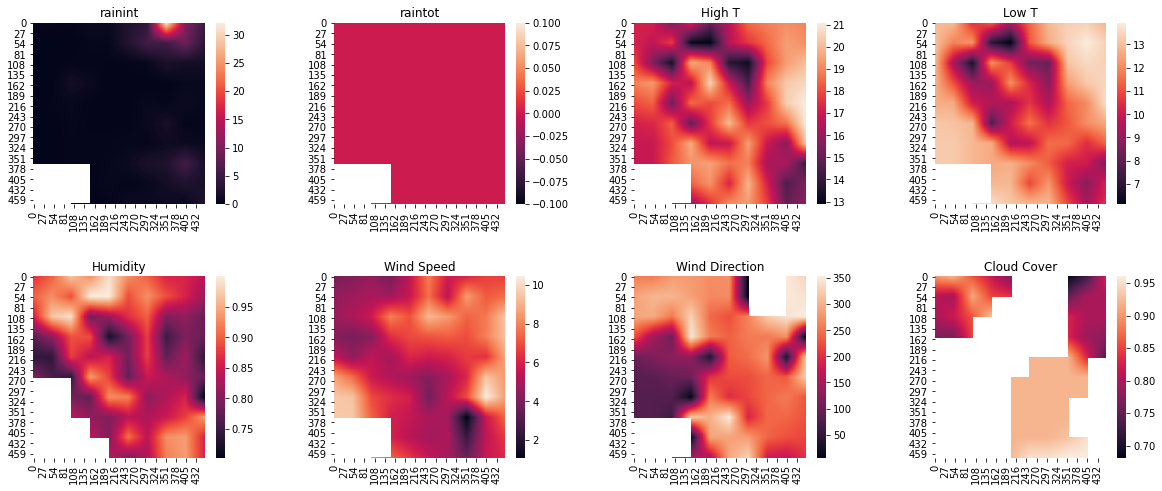

In [86]:
plot_weather(x1)

# Determine which days of the year we need data for

In [ ]:
# Use the firedata raster as the reference meta data and transform
with rio.open('../toydata/Global_fire_atlas_firelinecrop.tif','r') as rast:
    rastdata = rast.read(1)
    rastmeta = rast.meta

In [ ]:
rastdata.shape

In [ ]:
uniq = np.unique(rastdata, return_counts=True)
days = uniq[0]
counts = uniq[1]
# days = days[days > 0]  # remove the -9999 no data values
days

In [ ]:
print(len(days))

In [ ]:
# Cost for 2016:
nopoints = 10*10 # weather data on 10x10 grid
nodays = len(days) # number of unique days 
total_calls = nopoints * nodays
percall = 0.0001 # $0.0001 USD/call
free = 1000 # number free calls per day
cost = (total_calls - free)*percall
print(f"Cost to obtain data for all 2016 for cropped area is: ${cost} for {total_calls} total calls.")

In [ ]:
# Find date for given day of year
datetime.strptime('2016-100','%Y-%j')

In [ ]:
# Create list of dates for DOY on fireline
# dates = ['2016-12-16']
# time = date+'T12:00:00'
fire_dates = []
yr = '2016'
for day in days:
    s = yr + '-'+ str(day)
    d = datetime.strptime(s,'%Y-%j')
    s2 = str(d.strftime("%Y-%m-%d")) + 'T12:00:00'
    fire_dates.append(s2)
len(fire_dates)

Check if dates above cover the dates for the ignitions as well

In [ ]:
with open('../toydata/Global_fire_atlas_datacrop.pickle','rb') as f:
    firedbf = pickle.load(f)

In [ ]:
ign_dates = firedbf['start_date']

In [ ]:
ign_dates2 = []
for day in ign_dates:
    s3 = day + 'T12:00:00'
    ign_dates2.append(s3)

In [ ]:
# Check if ignition dates amongst the fireline dates
missed = set(ign_dates2).issubset(set(fire_dates))
missed

The ignition days are also within the fireline days, so just pickle out the arrays for each day.

## Sa